In [1]:
%run '00_database_connectivity_setup.ipynb'

# STATE STRATEGY

Only consider service orders with defined equipment numbers.
Only consider components with UOM of EA or PCE
Limit to Houston plants EWHG, HCS0, HCS1



## 1. Collect features:
    1.1 Service Orders SAPSR3./BIC/AZCS_O0100 
    1.2 Equipment sap_bi.bic_azequip00_int
    1.3 Material smithd2.material_features
    1.4 BOM smithd2.material_bom_exploded_enterprise
## 2. Cluster relevant materials
    2.1 Create table of materials on service orders
    2.2 Create distance metric
    2.3 Cluster
## 3. Create TARGET: component pctReplaced feature (Qty replaced / Qty serviced)
    3.1 Get Qty of each top level material serviced (with something replaced)
    3.2 Get Qty of each component exposed to service
    3.3 Get Qty of each component replaced
    3.4 Generate Metric
## 4. Create master table of features and Target
## 5. Predict qty of components to be replaced (with help from Data Robot)

# BEGIN PROCESS
## 1. Collect features:
    1.1 Service Orders SAPSR3./BIC/AZCS_O0100 
    1.2 Equipment sap_bi.bic_azequip00_int

In [55]:
%%execsql

--create service order table

DROP TABLE if EXISTS nate.sorders;
CREATE TABLE nate.sorders AS 

SELECT trim(leading '0' from a.cs_order) as Ordr, 
    b.material,
    coord_type, trim(leading '0' from a.equipment) as equipment,
    a.pmacttype, a.pmplangrp, a.planplant as plant, a.customer, a.ord_unplnd, a.bic_zsystatus as status, a.bic_zworkcntr as mainworkctr,
    a.bic_zqmnum as SN_num, 
    my_to_date(a.bic_zactrel, 'YYYYMMDD') as actreldate,
    my_to_date(a.finishdate, 'YYYYMMDD') as finishdate,
    my_to_date(a.bic_ztechcomp, 'YYYYMMDD') as tecodate
from sap_bi.bic_azcs_o0100_int a
JOIN 
    (
    select equipment, material
    from sap_bi.bic_azequip00_int
    where material>''
    group by equipment, material
    ) b
    ON a.equipment = b.equipment
where  a.equipment>'' and a.bic_zsystatus not like ('%NCMP%') 

DISTRIBUTED BY (material)


## 2. Cluster relevant materials
### 2.1 Create table of materials to be clustered

In [57]:
%%execsql
--get list of materials to be clustered
DROP TABLE if EXISTS nate.aro_components_HOU2;
CREATE TABLE nate.aro_components_HOU2 AS 
SELECT distinct b.material
    from nate.sorders a
    inner join data_science.ordercomponents_int b
    on a.ordr=b.ordr
    where b.plant in ('EWHG','HCS0', 'HCS1')
DISTRIBUTED BY(material);

In [58]:
%%showsql
SELECT COUNT(*) from nate.aro_components_HOU2;

,count
0,9252


In [60]:
%%execsql
DROP TABLE if EXISTS nate.aro_materials_HOU2;
CREATE TABLE nate.aro_materials_HOU2 AS 
 SELECT DISTINCT a.material 
    from nate.sorders a
    inner join data_science.ordercomponents_int b
    on a.ordr=b.ordr
    where b.plant in ('EWHG','HCS0', 'HCS1')
DISTRIBUTED BY (material);

In [61]:
%%showsql

select count(*) from nate.aro_materials_HOU2;

,count
0,2157


### 2.2 Create Distance metric

In [2]:
%%execsql
--create distance metrics
DROP TABLE IF EXISTS nate.material_features_distance_components_HOU2;
set statement_timeout = 0; 
CREATE TABLE nate.material_features_distance_components_HOU2 as
(    
    SELECT a.material as material, b.material as similar_material,     
     CASE WHEN a.material=b.material then 0
    --this case whenspeeds it up by limiting heavy math to at least one key field match
    WHEN
       ( a.prod_line = b.prod_line or a.model=b.model or  a.commodity_code=b.commodity_code
            or a.prod_family=b.prod_family or a.material=b.based_on or a.based_on=b.material or a.desc1=b.desc1) 
     THEN            
       ( case when a.weight>0.1 and b.weight>0.1 then 0.3 * (abs(a.weight-b.weight)/GREATEST(a.weight,b.weight)) else 0.1 end +    
        CASE WHEN a.model=b.model then 0 else 0.3 end +    
        case when a.material=b.based_on or a.based_on=a.material then 0 else 0.3 end +        
        (1.0 - smithd2.jaccard_index(a.documents, b.documents)) * .3 +   
        (1.0 - smithd2.jaccard_index(a.components, b.components)) * .4 + 
        case when char_length(a.desc1)>0 and char_length(b.desc1)>0 
            then 0.3 * pdltools.demerau_levenshtein_distance( a.desc1, b.desc1 )
                 / GREATEST(char_length(a.desc1),char_length(b.desc1))  
            else 0 end +    
        case when char_length(a.desc2)>0 and char_length(b.desc2)>0 
            then 0.2 * pdltools.demerau_levenshtein_distance( a.desc2, b.desc2 )
                 / GREATEST(char_length(a.desc2),char_length(b.desc2))  
            else 0 end + 
        case when char_length(a.desc3)>0 and char_length(b.desc3)>0 
            then 0.2 * pdltools.demerau_levenshtein_distance( a.desc3, b.desc3 )
                 / GREATEST(char_length(a.desc3),char_length(b.desc3))  
           else 0 end +
        case when char_length(a.desc4)>0 and char_length(b.desc4)>0 
           then 0.2 * pdltools.demerau_levenshtein_distance( a.desc4, b.desc4 )
                 / GREATEST(char_length(a.desc4),char_length(b.desc4))  
            else 0 end + 
        case when a.uom=b.uom then 0 else 0.3 end +
        case when a.prod_family=b.prod_family then 0 else 0.1 end +
        case when a.prod_line=b.prod_line then 0 else 0.1 end +
        (1.0 - smithd2.jaccard_index(a.matlspecs, b.matlspecs)) * .2 +
        (1.0 - smithd2.jaccard_index(a.weldspecs, b.weldspecs)) * .2 +
        case when a.serialization=b.serialization 
            or a.serialization is null and b.serialization is null then 0 
            when a.serialization is not null and b.serialization is not null         
            then 0.05 else 0.2 end +     
        (1.0 - smithd2.jaccard_index(a.qspecs, b.qspecs)) * .2 +
        (1.0 - smithd2.jaccard_index(a.qmsects, b.qmsects)) * .2 +       
        (1.0 - smithd2.jaccard_index(a.coatingspecs, b.coatingspecs)) * .2 +           
        case when a.material_type=b.material_type then 0 else 0.2 end +    
        case when a.commodity_code=b.commodity_code then 0 else 0.1 end) / 4.2
      ELSE 1.0 END
        as score
    FROM smithd2.material_features a
    INNER JOIN nate.aro_components_HOU2 c
    ON a.material = c.material
    CROSS JOIN smithd2.material_features b
    INNER JOIN  nate.aro_components_HOU2 d
    ON b.material = d.material
    where 
        a.material>=b.material  
)
DISTRIBUTED BY (material);

In [3]:
%%execsql
--create distance metrics
DROP TABLE IF EXISTS nate.material_features_distance_materials_HOU2;
set statement_timeout = 0; 
CREATE TABLE nate.material_features_distance_materials_HOU2 as
(    
    SELECT a.material as material, b.material as similar_material,     
     CASE WHEN a.material=b.material then 0
    --this case whenspeeds it up by limiting heavy math to at least one key field match
    WHEN
       ( a.prod_line = b.prod_line or a.model=b.model or  a.commodity_code=b.commodity_code
            or a.prod_family=b.prod_family or a.material=b.based_on or a.based_on=b.material or a.desc1=b.desc1) 
     THEN            
       ( case when a.weight>0.1 and b.weight>0.1 then 0.3 * (abs(a.weight-b.weight)/GREATEST(a.weight,b.weight)) else 0.1 end +    
        CASE WHEN a.model=b.model then 0 else 0.3 end +    
        case when a.material=b.based_on or a.based_on=a.material then 0 else 0.3 end +        
        (1.0 - smithd2.jaccard_index(a.documents, b.documents)) * .3 +   
        (1.0 - smithd2.jaccard_index(a.components, b.components)) * .4 + 
        case when char_length(a.desc1)>0 and char_length(b.desc1)>0 
            then 0.3 * pdltools.demerau_levenshtein_distance( a.desc1, b.desc1 )
                 / GREATEST(char_length(a.desc1),char_length(b.desc1))  
            else 0 end +    
        case when char_length(a.desc2)>0 and char_length(b.desc2)>0 
            then 0.2 * pdltools.demerau_levenshtein_distance( a.desc2, b.desc2 )
                 / GREATEST(char_length(a.desc2),char_length(b.desc2))  
            else 0 end + 
        case when char_length(a.desc3)>0 and char_length(b.desc3)>0 
            then 0.2 * pdltools.demerau_levenshtein_distance( a.desc3, b.desc3 )
                 / GREATEST(char_length(a.desc3),char_length(b.desc3))  
           else 0 end +
        case when char_length(a.desc4)>0 and char_length(b.desc4)>0 
           then 0.2 * pdltools.demerau_levenshtein_distance( a.desc4, b.desc4 )
                 / GREATEST(char_length(a.desc4),char_length(b.desc4))  
            else 0 end + 
        case when a.uom=b.uom then 0 else 0.3 end +
        case when a.prod_family=b.prod_family then 0 else 0.1 end +
        case when a.prod_line=b.prod_line then 0 else 0.1 end +
        (1.0 - smithd2.jaccard_index(a.matlspecs, b.matlspecs)) * .2 +
        (1.0 - smithd2.jaccard_index(a.weldspecs, b.weldspecs)) * .2 +
        case when a.serialization=b.serialization 
            or a.serialization is null and b.serialization is null then 0 
            when a.serialization is not null and b.serialization is not null         
            then 0.05 else 0.2 end +     
        (1.0 - smithd2.jaccard_index(a.qspecs, b.qspecs)) * .2 +
        (1.0 - smithd2.jaccard_index(a.qmsects, b.qmsects)) * .2 +       
        (1.0 - smithd2.jaccard_index(a.coatingspecs, b.coatingspecs)) * .2 +           
        case when a.material_type=b.material_type then 0 else 0.2 end +    
        case when a.commodity_code=b.commodity_code then 0 else 0.1 end) / 4.2
      ELSE 1.0 END
        as score
    FROM smithd2.material_features a
    INNER JOIN nate.aro_materials_HOU2 c
    ON a.material = c.material
    CROSS JOIN smithd2.material_features b
    INNER JOIN  nate.aro_materials_HOU2 d
    ON b.material = d.material
    where 
        a.material>=b.material  
)
DISTRIBUTED BY (material);

In [4]:
%%showsql

select count(*) from nate.material_features_distance_components_HOU2;

,count
0,26284875


In [5]:
%%showsql

select count(*) from nate.material_features_distance_materials_HOU2;

,count
0,1646205


In [6]:
sql = """
    select
        score
    from
        nate.material_features_distance_components_HOU2
    order by random()
    -- Take 100K random pairs of points
    limit 100000;
"""
dfc = psql.read_sql(sql, conn)
conn.commit()

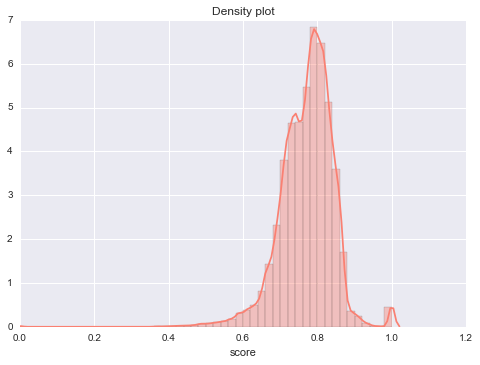

In [7]:
import seaborn as sns
sns.distplot(dfc['score'], color='salmon')
sns.plt.title('Density plot')
sns.plt.xlim(0)
sns.plt.show()

In [8]:
sql = """
    select
        score
    from
        nate.material_features_distance_materials_HOU2
    order by random()
    -- Take 100K random pairs of points
    limit 100000;
"""
dfm = psql.read_sql(sql, conn)
conn.commit()

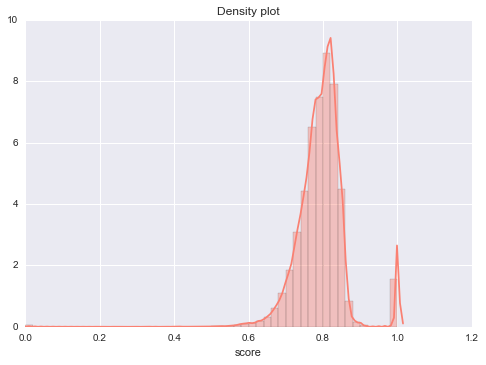

In [9]:
import seaborn as sns
sns.distplot(dfm['score'], color='salmon')
sns.plt.title('Density plot')
sns.plt.xlim(0)
sns.plt.show()

In [10]:
%%showsql
select
    ntile,
    min(score) as min_gower_dissimilarity_score,
    max(score) as max_gower_dissimilarity_score,
    avg(score) as mean_gower_dissimilarity_score
from
(
    select
        ntile(200) over( order by score) as ntile,
        score
    from
    (
        select
            score
        from
           nate.material_features_distance_components_HOU2        
        order by random()
        -- Take 100K random pairs of points
        limit 100000
    )q1
)q2
group by ntile
order by ntile
limit 2

,ntile,min_gower_dissimilarity_score,max_gower_dissimilarity_score,mean_gower_dissimilarity_score
0,1,0.000000,0.506000,0.433911
1,2,0.506262,0.554949,0.532327


In [11]:
%%showsql
select
    ntile,
    min(score) as min_gower_dissimilarity_score,
    max(score) as max_gower_dissimilarity_score,
    avg(score) as mean_gower_dissimilarity_score
from
(
    select
        ntile(200) over( order by score) as ntile,
        score
    from
    (
        select
            score
        from
          nate.material_features_distance_materials_HOU2        
        order by random()
        -- Take 100K random pairs of points
        limit 100000
    )q1
)q2
group by ntile
order by ntile
limit 2

,ntile,min_gower_dissimilarity_score,max_gower_dissimilarity_score,mean_gower_dissimilarity_score
0,1,0.000000,0.580114,0.408477
1,2,0.580284,0.620863,0.601868


### 2.3 Create Clusters

In [14]:
sql = """
drop table if exists nate.hclust_components45_HOU2;
create table nate.hclust_components45_HOU2
as
(
    select (result).material, (result).cluster_number
    from
    (
        select nate.run_hclust(key, 0.45) as result 
        from 
        (
            select
                nate.stack_rows( ARRAY['material', 'similar_material', 'score'],
                    material, 
                    similar_material, 
                    score) as key
            from nate.material_features_distance_components_HOU2
            where  material >= similar_material              
        ) q1
    ) q2
) distributed by (material);
"""
    
psql.execute(sql, conn)
conn.commit()

In [12]:
sql = """
drop table if exists nate.hclust_components55_HOU2;
create table nate.hclust_components55_HOU2
as
(
    select (result).material, (result).cluster_number
    from
    (
        select nate.run_hclust(key, 0.55) as result 
        from 
        (
            select
                nate.stack_rows( ARRAY['material', 'similar_material', 'score'],
                    material, 
                    similar_material, 
                    score) as key
            from nate.material_features_distance_components_HOU2
            where  material >= similar_material              
        ) q1
    ) q2
) distributed by (material);
"""
    
psql.execute(sql, conn)
conn.commit()

In [22]:
%%time
sql = """
drop table if exists nate.hclust_components65_HOU2old;
create table nate.hclust_components65_HOU2old
as
(
    select (result).material, (result).cluster_number
    from
    (
        select nate.run_hclust(key, 0.65) as result 
        from 
        (
            select
                nate.stack_rows( ARRAY['material', 'similar_material', 'score'],
                    material, 
                    similar_material, 
                    score) as key                    
            from nate.material_features_distance_components_HOU2
            where  material >= similar_material              
        ) q1
    ) q2
) distributed by (material);
"""
    
psql.execute(sql, conn)
conn.commit()

Wall time: 12min 47s


In [67]:
sql = """
drop table if exists nate.hclust_components75_HOU2;
create table nate.hclust_components75_HOU2
as
(
    select (result).material, (result).cluster_number
    from
    (
        select nate.run_hclust(key, 0.75) as result 
        from 
        (
            select
                nate.stack_rows( ARRAY['material', 'similar_material', 'score'],
                    material, 
                    similar_material, 
                    score) as key
            from nate.material_features_distance_components_HOU2
            where  material >= similar_material              
        ) q1
    ) q2
) distributed by (material);
"""
    
psql.execute(sql, conn)
conn.commit()

In [68]:
sql = """
drop table if exists nate.hclust_components85_HOU2;
create table nate.hclust_components85_HOU2
as
(
    select (result).material, (result).cluster_number
    from
    (
        select nate.run_hclust(key, 0.85) as result 
        from 
        (
            select
                nate.stack_rows( ARRAY['material', 'similar_material', 'score'],
                    material, 
                    similar_material, 
                    score) as key
            from nate.material_features_distance_components_HOU2
            where  material >= similar_material              
        ) q1
    ) q2
) distributed by (material);
"""
    
psql.execute(sql, conn)
conn.commit()

In [13]:
sql = """
drop table if exists nate.hclust_materials55_HOU2;
create table nate.hclust_materials55_HOU2
as
(
    select (result).material, (result).cluster_number
    from
    (
        select nate.run_hclust(key, 0.55) as result 
        from 
        (
            select
                nate.stack_rows( ARRAY['material', 'similar_material', 'score'],
                    material, 
                    similar_material, 
                    score) as key
            from nate.material_features_distance_materials_HOU2
            where  material >= similar_material              
        ) q1
    ) q2
) distributed by (material);
"""
    
psql.execute(sql, conn)
conn.commit()

In [17]:
%%time
sql = """
drop table if exists nate.hclust_materials65_HOU2old;
create table nate.hclust_materials65_HOU2old
as
(
    select (result).material, (result).cluster_number
    from
    (
        select nate.run_hclust(key, 0.55) as result 
        from 
        (
            select
                nate.stack_rows( ARRAY['material', 'similar_material', 'score'],
                    material, 
                    similar_material, 
                    score) as key
            from nate.material_features_distance_materials_HOU2
            where  material >= similar_material              
        ) q1
    ) q2
) distributed by (material);
"""
    
psql.execute(sql, conn)
conn.commit()

Wall time: 21.5 s


In [69]:
sql = """
drop table if exists nate.hclust_materials75_HOU2;
create table nate.hclust_materials75_HOU2
as
(
    select (result).material, (result).cluster_number
    from
    (
        select nate.run_hclust(key, 0.75) as result 
        from 
        (
            select
                nate.stack_rows( ARRAY['material', 'similar_material', 'score'],
                    material, 
                    similar_material, 
                    score) as key
            from nate.material_features_distance_materials_HOU2
            where  material >= similar_material              
        ) q1
    ) q2
) distributed by (material);
"""
    
psql.execute(sql, conn)
conn.commit()

In [70]:
# actually large, ran with 0.85
sql = """
drop table if exists nate.hclust_materials85_HOU2;
create table nate.hclust_materials85_HOU2
as
(
    select (result).material, (result).cluster_number
    from
    (
        select nate.run_hclust(key, 0.85) as result 
        from 
        (
            select
                nate.stack_rows( ARRAY['material', 'similar_material', 'score'],
                    material, 
                    similar_material, 
                    score) as key
            from nate.material_features_distance_materials_HOU2
            where  material >= similar_material              
        ) q1
    ) q2
) distributed by (material);
"""
    
psql.execute(sql, conn)
conn.commit()

In [21]:
%%showsql
SELECT max(cluster_number) from nate.hclust_components45_HOU2
limit 5;

,max
0,5375


In [16]:
%%showsql
SELECT count(*), max(cluster_number) from nate.hclust_components55_HOU2
limit 5;

,count,max
0,7250,3340


In [25]:
%%showsql
SELECT Count(*), max(cluster_number) from nate.hclust_components65_HOU2old
limit 5;

,count,max
0,7250,1650


In [8]:
%%showsql
SELECT count(*), max(cluster_number) from nate.hclust_components75_HOU2
limit 5;

,count,max
0,7250,558


In [9]:
%%showsql
SELECT count(*), max(cluster_number) from nate.hclust_components85_HOU2
limit 5;

,count,max
0,7250,102


In [15]:
%%showsql
SELECT count(*), max(cluster_number) from nate.hclust_materials55_HOU2
limit 5;

,count,max
0,1814,1113


In [25]:
%%showsql
SELECT max(cluster_number) from nate.hclust_materials65_HOU2
limit 5;

,max
0,596


In [73]:
%%showsql
SELECT max(cluster_number) from nate.hclust_materials75_HOU2
limit 5;

,max
0,227


In [74]:
%%showsql
SELECT max(cluster_number) from nate.hclust_materials85_HOU2
limit 5;

,max
0,43


## 3. Create TARGET: component pctReplaced feature (Qty replaced / Qty serviced)
### 3.1 With only components considered

In [110]:
%%execsql

--3.1 Get Qty of each top level material serviced (with something replaced)
DROP TABLE IF EXISTS nate.serviced_materials_HOU;
CREATE TABLE nate.serviced_materials_HOU AS 
(
    SELECT a.material, count(distinct b.ordr) as order_qty
    FROM nate.sorders a
    inner join data_science.ordercomponents_int b
    on a.ordr = b.ordr
    where a.plant in ('EWHG','HCS0', 'HCS1')
    group by 1
) DISTRIBUTED BY (material);

In [114]:
%%execsql
--3.2 Get Qty of each component exposed to service
DROP TABLE IF EXISTS nate.serviced_components_HOU;
CREATE TABLE nate.serviced_components_HOU AS 
(
    select c.material, d.component,  sum(c.order_qty*d.quantity) as qty_serviced
    from nate.serviced_materials_HOU c
    inner join smithd2.material_bom_exploded_enterprise d
    on c.material=d.material    
    WHERE d.unit in ('EA','PCE')
    group by 1, 2
) DISTRIBUTED BY (component);


In [116]:
%%execsql
--3.3 Get Qty of each component replaced
DROP TABLE IF EXISTS nate.replaced_components_HOU;
CREATE TABLE nate.replaced_components_HOU AS 
( 
    SELECT h.material, g.material as component, sum(g.qtywithdrawn) as qty_replaced
    from data_science.ordercomponents_int g
    inner join nate.sorders h 
    on g.ordr = h.ordr
    where g.plant in ('EWHG','HCS0', 'HCS1')
    and g.uom in ('EA','PCE')
    group by 1,2
) DISTRIBUTED BY (component);


In [120]:
%%execsql
--3.4 Generate Metric
DROP TABLE IF EXISTS nate.components_pct_replaced_HOU CASCADE;
CREATE TABLE nate.components_pct_replaced_HOU AS 
(
    SELECT e.material, e.component, 
            case when f.qty_replaced is null then 0 else f.qty_replaced end as qty_replaced,
            e.qty_serviced,
            case when f.qty_replaced is null or e.qty_serviced=0 then 0 
                else f.qty_replaced / e.qty_serviced end as pctReplaced 
    from  nate.serviced_components_HOU e
    left outer join nate.replaced_components_HOU f
    on e.material=f.material and e.component=f.component    
) DISTRIBUTED BY (component);

In [121]:
%%showsql
select * from  nate.components_pct_replaced_HOU
limit 100;

,material,component,qty_replaced,qty_serviced,pctreplaced
0,P1000003121,P157531,0.0,4.0,0.000000
1,P1000005255,100002870,0.0,600.0,0.000000
2,P1000005255,100019603,0.0,24.0,0.000000
3,P1000005255,100022731,0.0,360.0,0.000000
4,P1000005255,100026476,0.0,360.0,0.000000
5,P1000005255,100030282,0.0,9600.0,0.000000
6,P1000005255,100033852,0.0,960.0,0.000000
7,P1000005255,100044999,0.0,1440.0,0.000000
8,P1000005255,200004268,0.0,2880.0,0.000000
9,P1000005255,200006529,0.0,19200.0,0.000000


### 3.2 considering component, material, ord_type, pmacttype, plant

In [26]:
%%execsql

--3.1 Get Qty of each top level material serviced (with something replaced)
DROP TABLE IF EXISTS nate.serviced_materials_HOU2;
CREATE TABLE nate.serviced_materials_HOU2 AS 
(
    SELECT a.material, a.plant, a.coord_type, a.pmacttype,
    count(distinct b.ordr) as order_qty
    FROM nate.sorders a
    inner join data_science.ordercomponents_int b
    on a.ordr = b.ordr
    where a.plant in ('EWHG','HCS0', 'HCS1')
    group by 1, 2, 3, 4
) DISTRIBUTED BY (material);

In [27]:
%%execsql
--3.2 Get Qty of each component exposed to service
DROP TABLE IF EXISTS nate.serviced_components_HOU2;
CREATE TABLE nate.serviced_components_HOU2 AS 
(
    select c.material, c.plant, c.coord_type, c.pmacttype, d.component,  sum(c.order_qty*d.quantity) as qty_serviced
    from nate.serviced_materials_HOU2 c
    inner join smithd2.material_bom_exploded_enterprise d
    on c.material=d.material
    where c.plant in ('EWHG','HCS0', 'HCS1')
    AND d.unit in ('EA','PCE')
    group by 1, 2, 3, 4, 5
) DISTRIBUTED BY (component);


In [28]:
%%execsql
--3.3 Get Qty of each component replaced
DROP TABLE IF EXISTS nate.replaced_components_HOU2;
CREATE TABLE nate.replaced_components_HOU2 AS 
( 
    SELECT h.material, h.plant, h.coord_type, h.pmacttype, g.material as component, sum(g.qtywithdrawn) as qty_replaced
    from data_science.ordercomponents_int g
    inner join nate.sorders h 
    on g.ordr = h.ordr
    where h.plant in ('EWHG','HCS0', 'HCS1')
    and g.uom in ('EA','PCE')
    group by 1,2,3, 4, 5
) DISTRIBUTED BY (component);


In [29]:
%%execsql
--3.4 Generate Metric
DROP TABLE IF EXISTS nate.components_pct_replaced_HOU2;
CREATE TABLE nate.components_pct_replaced_HOU2 AS 
(
    SELECT e.material, e.plant, e.coord_type, e.pmacttype, e.component, 
            case when f.qty_replaced is null then 0 else f.qty_replaced end as qty_replaced,
            e.qty_serviced,
            case when f.qty_replaced is null or e.qty_serviced=0 then 0 
                else f.qty_replaced / e.qty_serviced end as pctReplaced 
    from  nate.serviced_components_HOU2 e
    left outer join nate.replaced_components_HOU2 f
    on e.material=f.material and e.plant=f.plant and e.component=f.component and e.coord_type=f.coord_type 
        and e.pmacttype=f.pmacttype
    where e.plant in ('EWHG','HCS0', 'HCS1')
    
) DISTRIBUTED BY (component);

In [30]:
%%showsql
select * from  nate.components_pct_replaced_HOU2
limit 100;

,material,plant,coord_type,pmacttype,component,qty_replaced,qty_serviced,pctreplaced
0,19-200-900,HCS0,ZS04,010,19-200-901,0.0,2.0,0.000000
1,19-200-900,HCS0,ZS04,013,19-200-901,1.0,1.0,1.000000
2,19-200-900,HCS0,ZS04,023,19-200-901,0.0,1.0,0.000000
3,19-200-900,HCS0,ZS04,130,19-200-901,0.0,1.0,0.000000
4,19-200-900,HCS0,ZS04,131,19-200-901,0.0,1.0,0.000000
5,P1000009151,HCS0,ZS04,010,701-073-499,0.0,10.0,0.000000
6,P1000009151,HCS0,ZS04,010,P107383,30.0,30.0,1.000000
7,P1000009151,HCS0,ZS04,023,701-073-499,0.0,4.0,0.000000
8,P1000009151,HCS0,ZS04,023,P107383,6.0,12.0,0.500000
9,P1000009151,HCS0,ZS04,130,701-073-499,0.0,6.0,0.000000


### 3.3 Considering lots of material and order features

In [132]:
%%execsql

--3.1 Get Qty of each top level material serviced (with something replaced)
DROP TABLE IF EXISTS nate.serviced_materials_HOU3;
CREATE TABLE nate.serviced_materials_HOU3 AS 
(
    SELECT a.material, a.plant, a.coord_type, a.pmacttype, a.pmplangrp, a.customer, a.ord_unplnd, a.mainworkctr, 
    count(distinct b.ordr) as order_qty
    FROM nate.sorders a
    inner join data_science.ordercomponents_int b
    on a.ordr = b.ordr
    where a.plant in ('EWHG','HCS0', 'HCS1')
    group by 1, 2, 3, 4, 5, 6, 7, 8
) DISTRIBUTED BY (material);

In [133]:
%%execsql
--3.2 Get Qty of each component exposed to service
DROP TABLE IF EXISTS nate.serviced_components_HOU3;
CREATE TABLE nate.serviced_components_HOU3 AS 
(
    select a.material, a.plant, a.coord_type, a.pmacttype, a.pmplangrp, a.customer, a.ord_unplnd, a.mainworkctr, 
    d.component,  sum(a.order_qty*d.quantity) as qty_serviced
    from nate.serviced_materials_HOU3 a
    inner join smithd2.material_bom_exploded_enterprise d
    on a.material=d.material
    where a.plant in ('EWHG','HCS0', 'HCS1')
    AND d.unit in ('EA','PCE')
    group by 1, 2, 3, 4, 5, 6, 7, 8, 9
) DISTRIBUTED BY (component);


In [138]:
%%execsql
--3.3 Get Qty of each component replaced
DROP TABLE IF EXISTS nate.replaced_components_HOU3;
CREATE TABLE nate.replaced_components_HOU3 AS 
( 
    SELECT h.material, h.plant, h.coord_type, h.pmacttype, h.pmplangrp, h.customer, h.ord_unplnd, h.mainworkctr,
    g.material as component, sum(g.qtywithdrawn) as qty_replaced
    from data_science.ordercomponents_int g
    inner join nate.sorders h 
    on g.ordr = h.ordr
    where h.plant in ('EWHG','HCS0', 'HCS1')
    and g.uom in ('EA','PCE')
    group by 1,2,3,4,5,6,7,8,9
) DISTRIBUTED BY (component);


In [139]:
%%execsql
--3.4 Generate Metric
DROP TABLE IF EXISTS nate.components_pct_replaced_HOU3;
CREATE TABLE nate.components_pct_replaced_HOU3 AS 
(
    SELECT e.material, e.plant, e.coord_type, e.pmacttype, e.pmplangrp, e.customer, e.ord_unplnd, e.mainworkctr, 
        e.component, 
            case when f.qty_replaced is null then 0 else f.qty_replaced end as qty_replaced,
            e.qty_serviced,
            case when f.qty_replaced is null or e.qty_serviced=0 then 0 
                else f.qty_replaced / e.qty_serviced end as pctReplaced 
    from  nate.serviced_components_HOU3 e
    left outer join nate.replaced_components_HOU3 f
    on e.material=f.material and e.plant=f.plant
    and e.coord_type=f.coord_type and e.pmacttype=f.pmacttype and e.pmplangrp = f.pmplangrp 
    and e.customer=f.customer  and e.ord_unplnd= f.ord_unplnd and  e.mainworkctr= f.mainworkctr and e.component=f.component 
    
) DISTRIBUTED BY (component);

In [140]:
%%showsql
select * from  nate.components_pct_replaced_HOU3
limit 100;

,material,plant,coord_type,pmacttype,pmplangrp,customer,ord_unplnd,mainworkctr,component,qty_replaced,qty_serviced,pctreplaced
0,18-909-066,HCS0,ZS04,010,220,CEWHG,1,00008010,18-909-167,112.0,128.0,0.875000
1,18-909-066,HCS0,ZS04,010,250,CEWHG,1,00008010,18-909-167,16.0,16.0,1.000000
2,18-909-066,HCS0,ZS04,013,220,CEWHG,1,00008010,18-909-167,24.0,24.0,1.000000
3,18-909-066,HCS0,ZS04,014,200,CEWHG,1,00008010,18-909-167,16.0,24.0,0.666667
4,18-909-066,HCS0,ZS04,023,220,CEWHG,1,00008010,18-909-167,56.0,64.0,0.875000
5,18-909-066,HCS0,ZS04,131,255,CEWHG,1,00008010,18-909-167,24.0,48.0,0.500000
6,P1000003515,EWHG,ZS04,013,200,0000046409,1,CNLARGE,7106021,0.0,8.0,0.000000
7,P1000003515,EWHG,ZS04,013,200,0000046409,1,CNLARGE,7107862,0.0,20.0,0.000000
8,P1000003515,EWHG,ZS04,013,200,0000046409,1,CNLARGE,P1000044154,0.0,1.0,0.000000
9,P1000009423,HCS0,ZS03,002,200,CEWHG,1,00008010,P1000128609,0.0,1.0,0.000000


## 4. Create master table of features and Target

### 4.1 Components only


In [144]:
%%execsql
DROP TABLE IF EXISTS nate.component_features_HOU;
CREATE TABLE nate.component_features_HOU
AS 
(
    SELECT  a.component,  
     a.qty_replaced, a.qty_serviced, a.pctreplaced,       
       
    c.weight as c_weight,
    c.material_type as c_material_type,  
    c.material_group as c_material_group,    
    c.surface_matl as c_surface_matl, 
    c.subsea_matl as c_subsea_matl,     
    (c.material_type is not null) as c_has_materialtype,
    (c.coatingspecs is not null) as c_has_coatings,
    (c.documents is not null) as c_has_documents, 
    (c.matlspecs is not null) as c_has_matlspecs,
    (c.weldspecs is not null) as c_has_weldspecs, 
    (c.qspecs is not null) as c_has_qspecs,    
   
    f.cluster_number::text as c_clust75,
    g.cluster_number::text as c_clust85
   
    FROM  nate.components_pct_replaced_HOU a    
    INNER JOIN smithd2.material_features c  ON a.component = c.material     
    INNER join nate.hclust_components75_HOU2 f on a.component = f.material
    INNER join nate.hclust_components85_HOU2 g on a.component = g.material
) DISTRIBUTED BY (component);


In [152]:
%%showsql 
SELECT count(*), sum(qty_replaced) FROM  nate.component_features_HOU
limit 10;

,count,sum
0,75908,257462.0


### 4.2 Materials, Components, ord_type, pmacttype, and plant

In [31]:
%%execsql
DROP TABLE IF EXISTS nate.component_features_HOU2;
CREATE TABLE nate.component_features_HOU2
AS 
(
    SELECT  a.component, a.material, 
    a.plant, a.coord_type, a.pmacttype, a.qty_replaced, a.qty_serviced, --a.pctreplaced,      
    
    b."desc" as m_desc, 
    b.desc1 as m_desc1, 
    b.weight as m_weight,
    b.material_type as m_material_type,  
    b.material_group as m_material_group,    
    b.surface_matl as m_surface_matl, 
    b.subsea_matl as m_subsea_matl,     
    (b.material_type is not null) as m_has_materialtype,
    (b.coatingspecs is not null) as m_has_coatings,
    (b.documents is not null) as m_has_documents, 
    (b.matlspecs is not null) as m_has_matlspecs,
    (b.weldspecs is not null) as m_has_weldspecs, 
    (b.qspecs is not null) as m_has_qspecs,
    
    c."desc" as c_desc,
    c.desc1 as c_desc1,
    c.weight as c_weight,
    c.material_type as c_material_type,  
    c.material_group as c_material_group,    
    c.surface_matl as c_surface_matl, 
    c.subsea_matl as c_subsea_matl,     
    (c.material_type is not null) as c_has_materialtype,
    (c.coatingspecs is not null) as c_has_coatings,
    (c.documents is not null) as c_has_documents, 
    (c.matlspecs is not null) as c_has_matlspecs,
    (c.weldspecs is not null) as c_has_weldspecs, 
    (c.qspecs is not null) as c_has_qspecs,
    
    d.cluster_number::text as m_clust55,
    e.cluster_number::text as m_clust65,
    f.cluster_number::text as m_clust75,
    g.cluster_number::text as m_clust85,
    
    h.cluster_number::text as c_clust45,
    i.cluster_number::text as c_clust55,
    j.cluster_number::text as c_clust65,
    k.cluster_number::text as c_clust75,
    l.cluster_number::text as c_clust85
   
    FROM  nate.components_pct_replaced_HOU2 a
    INNER JOIN smithd2.material_features b  ON a.material = b.material
    INNER JOIN smithd2.material_features c  ON a.component = c.material 
    
    INNER join nate.hclust_materials55_HOU2 d on a.material = d.material
    INNER join nate.hclust_materials65_HOU2 e on a.material = e.material
    INNER join nate.hclust_materials75_HOU2 f on a.material = f.material
    INNER join nate.hclust_materials85_HOU2 g on a.material = g.material
    
    INNER join nate.hclust_components45_HOU2 h on a.component = h.material
    INNER join nate.hclust_components55_HOU2 i on a.component = i.material
    INNER join nate.hclust_components65_HOU2 j on a.component = j.material
    INNER join nate.hclust_components75_HOU2 k on a.component = k.material
    INNER join nate.hclust_components85_HOU2 l on a.component = l.material
) DISTRIBUTED BY (component);


In [32]:
%%showsql 
SELECT count(*), sum(qty_replaced) FROM  nate.component_features_HOU2
limit 10;

,count,sum
0,192287,244097.0


In [2]:
%%showsql 
SELECT * FROM  nate.component_features_HOU2
where m_desc like 'SCM%'
limit 10;

,component,material,plant,coord_type,pmacttype,qty_replaced,qty_serviced,m_desc,m_desc1,m_weight,m_material_type,m_material_group,m_surface_matl,m_subsea_matl,m_has_materialtype,m_has_coatings,m_has_documents,m_has_matlspecs,m_has_weldspecs,m_has_qspecs,c_desc,c_desc1,c_weight,c_material_type,c_material_group,c_surface_matl,c_subsea_matl,c_has_materialtype,c_has_coatings,c_has_documents,c_has_matlspecs,c_has_weldspecs,c_has_qspecs,m_clust55,m_clust65,m_clust75,m_clust85,c_clust45,c_clust55,c_clust65,c_clust75,c_clust85
0,P6000075114,P6000121958,HCS0,ZS04,023,0.0,2.0,"SCM MK II, 615, MARSHALL MADISON 615",SCM MK II,0.0,HALB,A-SCM-NSA,True,True,True,False,True,False,False,False,"ELECTRICAL COMPONENTS, POWER SUPPLY, ASSY, PWM604 - 320W - 1 X 28V DC 160W + 1 X 24V DC 160W + 1 X 5V DC 2, 5W",ELECTRICAL COMPONENTS,2.2,HALB,O-T01-EP0,True,True,True,False,True,False,False,False,616,324,124,27,891,498,207,66,20
1,P6000075114,P6000100953,HCS0,ZS04,136,0.0,4.0,"SCM MK II, 620, LLOG DELTA HOUSE",SCM MK II,3274.0,HALB,A-SCM-NSA,False,True,True,False,True,False,False,False,"ELECTRICAL COMPONENTS, POWER SUPPLY, ASSY, PWM604 - 320W - 1 X 28V DC 160W + 1 X 24V DC 160W + 1 X 5V DC 2, 5W",ELECTRICAL COMPONENTS,2.2,HALB,O-T01-EP0,True,True,True,False,True,False,False,False,621,324,124,27,891,498,207,66,20
2,P6000075114,P6000100953,HCS0,ZS04,130,0.0,8.0,"SCM MK II, 620, LLOG DELTA HOUSE",SCM MK II,3274.0,HALB,A-SCM-NSA,False,True,True,False,True,False,False,False,"ELECTRICAL COMPONENTS, POWER SUPPLY, ASSY, PWM604 - 320W - 1 X 28V DC 160W + 1 X 24V DC 160W + 1 X 5V DC 2, 5W",ELECTRICAL COMPONENTS,2.2,HALB,O-T01-EP0,True,True,True,False,True,False,False,False,621,324,124,27,891,498,207,66,20
3,P6000075114,P6000100953,HCS0,ZS04,023,0.0,4.0,"SCM MK II, 620, LLOG DELTA HOUSE",SCM MK II,3274.0,HALB,A-SCM-NSA,False,True,True,False,True,False,False,False,"ELECTRICAL COMPONENTS, POWER SUPPLY, ASSY, PWM604 - 320W - 1 X 28V DC 160W + 1 X 24V DC 160W + 1 X 5V DC 2, 5W",ELECTRICAL COMPONENTS,2.2,HALB,O-T01-EP0,True,True,True,False,True,False,False,False,621,324,124,27,891,498,207,66,20
4,P6000075114,P6000100953,HCS0,ZS04,020,0.0,4.0,"SCM MK II, 620, LLOG DELTA HOUSE",SCM MK II,3274.0,HALB,A-SCM-NSA,False,True,True,False,True,False,False,False,"ELECTRICAL COMPONENTS, POWER SUPPLY, ASSY, PWM604 - 320W - 1 X 28V DC 160W + 1 X 24V DC 160W + 1 X 5V DC 2, 5W",ELECTRICAL COMPONENTS,2.2,HALB,O-T01-EP0,True,True,True,False,True,False,False,False,621,324,124,27,891,498,207,66,20
5,P6000075114,P6000100953,HCS0,ZS04,004,0.0,4.0,"SCM MK II, 620, LLOG DELTA HOUSE",SCM MK II,3274.0,HALB,A-SCM-NSA,False,True,True,False,True,False,False,False,"ELECTRICAL COMPONENTS, POWER SUPPLY, ASSY, PWM604 - 320W - 1 X 28V DC 160W + 1 X 24V DC 160W + 1 X 5V DC 2, 5W",ELECTRICAL COMPONENTS,2.2,HALB,O-T01-EP0,True,True,True,False,True,False,False,False,621,324,124,27,891,498,207,66,20
6,P6000075114,P6000098616,HCS0,ZS04,130,0.0,2.0,"SCM MK II, 620, 2011 SHELL STD 15K, DHI212/DHI205",SCM MK II,3307.0,HALB,A-SCM-NSA,False,True,True,False,True,False,False,False,"ELECTRICAL COMPONENTS, POWER SUPPLY, ASSY, PWM604 - 320W - 1 X 28V DC 160W + 1 X 24V DC 160W + 1 X 5V DC 2, 5W",ELECTRICAL COMPONENTS,2.2,HALB,O-T01-EP0,True,True,True,False,True,False,False,False,622,324,124,27,891,498,207,66,20
7,P6000075114,P6000102554,HCS0,ZS04,130,0.0,2.0,"SCM MK II, 620, ANADARKO STD",SCM MK II,3314.0,HALB,A-SCM-NSA,False,True,True,False,True,False,False,False,"ELECTRICAL COMPONENTS, POWER SUPPLY, ASSY, PWM604 - 320W - 1 X 28V DC 160W + 1 X 24V DC 160W + 1 X 5V DC 2, 5W",ELECTRICAL COMPONENTS,2.2,HALB,O-T01-EP0,True,True,True,False,True,False,False,False,621,324,124,27,891,498,207,66,20
8,P6000034044,P1000090762,HCS0,ZS01,010,0.0,12.0,"SCM MK II, 150, XT, NEXEN GREEN CANYON RECOVERY",SCM MK II,2046.0,HALB,A-SCM-NSA,False,True,True,False,False,False,False,False,"O-RING, .079 IN (2.00 MM) CS X .354 IN (9.00 MM) ID, NON STANDARD , E53009 HNBR, 90 DURO, KONGSBERG CRITICAL APPS MATL, MOLDED",O-RING,0.1,HALB,O-S04-ST0,Tr

In [3]:
%%showsql 
SELECT * FROM  nate.component_features_HOU2
where m_clust65=324
limit 10;

,component,material,plant,coord_type,pmacttype,qty_replaced,qty_serviced,m_desc,m_desc1,m_weight,m_material_type,m_material_group,m_surface_matl,m_subsea_matl,m_has_materialtype,m_has_coatings,m_has_documents,m_has_matlspecs,m_has_weldspecs,m_has_qspecs,c_desc,c_desc1,c_weight,c_material_type,c_material_group,c_surface_matl,c_subsea_matl,c_has_materialtype,c_has_coatings,c_has_documents,c_has_matlspecs,c_has_weldspecs,c_has_qspecs,m_clust55,m_clust65,m_clust75,m_clust85,c_clust45,c_clust55,c_clust65,c_clust75,c_clust85
0,P6000070062,P6000121958,HCS0,ZS04,023,0.0,4.0,"SCM MK II, 615, MARSHALL MADISON 615",SCM MK II,0.0,HALB,A-SCM-NSA,True,True,True,False,True,False,False,False,"SOCKET CAP SCREW, ISO 4762, M10 X 75MM LG, M40118, INCONEL 718, UNCOATED",SOCKET CAP SCREW,0.11,HALB,O-F03-000,True,True,True,False,True,True,False,False,616,324,124,27,1909,922,386,109,24
1,P6000070062,P6000093501,HCS0,ZS04,010,0.0,8.0,"OBSOLETE AND REPLACED BY P6000107981. SCM MK II, 615, LLOG 615",OBSOLETE AND REPLACED BY P6000107981. SCM MK II,2730.0,HALB,A-SCM-NSA,False,True,True,False,True,False,False,False,"SOCKET CAP SCREW, ISO 4762, M10 X 75MM LG, M40118, INCONEL 718, UNCOATED",SOCKET CAP SCREW,0.11,HALB,O-F03-000,True,True,True,False,True,True,False,False,624,324,124,27,1909,922,386,109,24
2,P6000070062,P6000043714,HCS0,ZS04,010,0.0,24.0,"SCM MK II E, 150, PROD XT, CAS-CHIN",SCM MK II E,2703.0,HALB,A-SCM-NSA,False,True,True,False,True,False,False,False,"SOCKET CAP SCREW, ISO 4762, M10 X 75MM LG, M40118, INCONEL 718, UNCOATED",SOCKET CAP SCREW,0.11,HALB,O-F03-000,True,True,True,False,True,True,False,False,618,324,124,27,1909,922,386,109,24
3,P6000070062,P6000043714,EWHG,ZS04,013,0.0,16.0,"SCM MK II E, 150, PROD XT, CAS-CHIN",SCM MK II E,2703.0,HALB,A-SCM-NSA,False,True,True,False,True,False,False,False,"SOCKET CAP SCREW, ISO 4762, M10 X 75MM LG, M40118, INCONEL 718, UNCOATED",SOCKET CAP SCREW,0.11,HALB,O-F03-000,True,True,True,False,True,True,False,False,618,324,124,27,1909,922,386,109,24
4,P6000070062,P6000043714,EWHG,ZS04,004,0.0,8.0,"SCM MK II E, 150, PROD XT, CAS-CHIN",SCM MK II E,2703.0,HALB,A-SCM-NSA,False,True,True,False,True,False,False,False,"SOCKET CAP SCREW, ISO 4762, M10 X 75MM LG, M40118, INCONEL 718, UNCOATED",SOCKET CAP SCREW,0.11,HALB,O-F03-000,True,True,True,False,True,True,False,False,618,324,124,27,1909,922,386,109,24
5,P6000070062,P6000100953,HCS0,ZS04,136,0.0,8.0,"SCM MK II, 620, LLOG DELTA HOUSE",SCM MK II,3274.0,HALB,A-SCM-NSA,False,True,True,False,True,False,False,False,"SOCKET CAP SCREW, ISO 4762, M10 X 75MM LG, M40118, INCONEL 718, UNCOATED",SOCKET CAP SCREW,0.11,HALB,O-F03-000,True,True,True,False,True,True,False,False,621,324,124,27,1909,922,386,109,24
6,P6000070062,P6000100953,HCS0,ZS04,130,0.0,16.0,"SCM MK II, 620, LLOG DELTA HOUSE",SCM MK II,3274.0,HALB,A-SCM-NSA,False,True,True,False,True,False,False,False,"SOCKET CAP SCREW, ISO 4762, M10 X 75MM LG, M40118, INCONEL 718, UNCOATED",SOCKET CAP SCREW,0.11,HALB,O-F03-000,True,True,True,False,True,True,False,False,621,324,124,27,1909,922,386,109,24
7,P6000070062,P6000100953,HCS0,ZS04,023,0.0,8.0,"SCM MK II, 620, LLOG DELTA HOUSE",SCM MK II,3274.0,HALB,A-SCM-NSA,False,True,True,False,True,False,False,False,"SOCKET CAP SCREW, ISO 4762, M10 X 75MM LG, M40118, INCONEL 718, UNCOATED",SOCKET CAP SCREW,0.11,HALB,O-F03-000,True,True,True,False,True,True,False,False,621,324,124,27,1909,922,386,109,24
8,P6000070062,P6000100953,HCS0,ZS04,020,0.0,8.0,"SCM MK II, 620, LLOG DELTA HOUSE",SCM MK II,3274.0,HALB,A-SCM-NSA,False,True,True,False,True,False,False,False,"SOCKET CAP SCREW, ISO 4762, M10 X 75MM LG, M40118, INCONEL 718, UNCOATED",SOCKET CAP SCREW,0.11,HALB,O-F03-000,True,True,True,False,True,True,False,False,621,324,124,27,1909,922,386,109,24
9,P6000070062,P6000100953,HCS0,ZS04,004,0.0,8.0,"SCM MK II, 620, LLOG DELTA HOUSE",SCM MK II,3274.0,HALB,A-SCM-NSA,False,True,True,False,True,False,False,False,"SOCKET CAP SCREW, ISO 4762, M10 X 75MM LG, M40118, INCONEL 718, UNCOATED",SOCK

In [1]:
%%showsql 
SELECT c_desc FROM  nate.component_features_HOU2
where c_clust55=596
limit 10000;

ERROR: Cell magic `%%showsql` not found.


### 4.3 Lots of features

In [148]:
%%execsql
DROP TABLE IF EXISTS nate.component_features_HOU3;
CREATE TABLE nate.component_features_HOU3
AS 
(
    SELECT  a.component, a.material, a.plant, 
    a.coord_type, a.pmacttype, a.pmplangrp, a.customer, a.ord_unplnd, a.mainworkctr, 
    a.qty_replaced, a.qty_serviced, a.pctreplaced,       
    b.weight as m_weight,
    b.material_type as m_material_type,  
    b.material_group as m_material_group,    
    b.surface_matl as m_surface_matl, 
    b.subsea_matl as m_subsea_matl,     
    (b.material_type is not null) as m_has_materialtype,
    (b.coatingspecs is not null) as m_has_coatings,
    (b.documents is not null) as m_has_documents, 
    (b.matlspecs is not null) as m_has_matlspecs,
    (b.weldspecs is not null) as m_has_weldspecs, 
    (b.qspecs is not null) as m_has_qspecs,
    
    c.weight as c_weight,
    c.material_type as c_material_type,  
    c.material_group as c_material_group,    
    c.surface_matl as c_surface_matl, 
    c.subsea_matl as c_subsea_matl,     
    (c.material_type is not null) as c_has_materialtype,
    (c.coatingspecs is not null) as c_has_coatings,
    (c.documents is not null) as c_has_documents, 
    (c.matlspecs is not null) as c_has_matlspecs,
    (c.weldspecs is not null) as c_has_weldspecs, 
    (c.qspecs is not null) as c_has_qspecs,
    
    d.cluster_number::text as m_clust75,
    e.cluster_number::text as m_clust85,
    f.cluster_number::text as c_clust75,
    g.cluster_number::text as c_clust85
   
    FROM  nate.components_pct_replaced_HOU3 a
    INNER JOIN smithd2.material_features b  ON a.material = b.material
    INNER JOIN smithd2.material_features c  ON a.component = c.material  
    INNER join nate.hclust_materials75_HOU2 d on a.material = d.material
    INNER join nate.hclust_materials85_HOU2 e on a.material = e.material
    INNER join nate.hclust_components75_HOU2 f on a.component = f.material
    INNER join nate.hclust_components85_HOU2 g on a.component = g.material
) DISTRIBUTED BY (component);


In [150]:
%%showsql 
SELECT count(*), sum(qty_replaced) FROM  nate.component_features_HOU3
limit 10;

,count,sum
0,258604,244097.0


# SCRATCH

In [99]:
%%showsql
SELECT sum(qtywithdrawn)
from
data_science.ordercomponents_int a
inner join nate.sorders b
 on a.ordr=b.ordr
where a.plant in ('EWHG','HCS0', 'HCS1')
and a.uom in ('EA','PCE')
limit 10

,sum
0,408385.0


In [106]:
%%showsql
SELECT SUM(qty_replaced)
FROM(
SELECT  a.component, a.material, 
    a.plant, a.qty_replaced, a.qty_serviced, a.pctreplaced     
    
   
    FROM  nate.components_pct_replaced_HOU2 a
    INNER JOIN smithd2.material_features b  ON a.material = b.material
    INNER JOIN smithd2.material_features c  ON a.component = c.material  
    INNER join nate.hclust_materials75_HOU2 d on a.material = d.material
    INNER join nate.hclust_materials85_HOU2 e on a.material = e.material
    INNER join nate.hclust_components75_HOU2 f on a.component = f.material
    INNER join nate.hclust_components85_HOU2 g on a.component = g.material
) aa

,sum
0,244097.0
